<a href="https://colab.research.google.com/github/harmonicfunc/LogicalRhythm2k23/blob/main/LR_ps3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'anyas-gojo-revival-aerospace-enigma:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F63134%2F6880857%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240405%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240405T175846Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D5bd3cabb2431f50cabb9e7a5d6e17004ca752e288330d4a0b3a14ce7a21871a14c899848464461d845232073774d8120cf5129a984ff462771b8667a22cc10a89ce96596bfd999b3e0b7f9d37c5f437d08019a6bfccefe02cf74633dd4e03ce4965de1fe378f9c180dfe985e84a329347726a2a98e60eda8255a21d08b2751b1d48815e5b136664773ad1e73820f4520a746e1bb6a4d4600f8ab57b3128a452eefc64516dc46f5a0cef831e0ae95e8e61ac9de7d7882947563dd501eb6e2236a015e2aafc5eb6fd47a38edcb85c87bae1f5e73a0708117d6d3174247715c464bc969d69b763304ad318ee07bd10200e91f4b3626eb37bfbf60d2bab15fc64379'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 149033162 bytes downloaded
Downloaded and uncompressed: anyas-gojo-revival-aerospace-enigma
Data source import complete.


# Importing Relevant Modules

In [2]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
# from keras.layers.normalization import BatchNormalization
from keras.layers import Input, Lambda, Dense, Flatten, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import applications

In [3]:
train = list(os.walk('/kaggle/input/anyas-gojo-revival-aerospace-enigma/train'))

In [4]:
label_names = train[0][1]
dict_labels = dict(zip(label_names, list(range(len(label_names)))))
print(dict_labels)

{'glider': 0, 'helicopter': 1, 'mig-29': 2, 'sukhoi': 3, 'commercial': 4}


# EDA

In [5]:
def dataset(path): #put path till the highest directory level
    images = []
    labels = []
    for folder in tqdm(os.listdir(path)):
        value_of_label = dict_labels[folder] #dict_labels is the dictionary whose key:value pairs are classes:numbers representing them

        for file in (os.listdir(os.path.join(path, folder))):
            path_of_file = os.path.join(os.path.join(path, folder), file)

            image = cv2.imread(path_of_file)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (150, 150))
            images.append(image)
            labels.append(value_of_label)

    images = np.array(images, dtype = 'float32')/255.0
    labels = np.array(labels)

    return images, labels

images, labels = dataset('/kaggle/input/anyas-gojo-revival-aerospace-enigma/train')
images, labels = shuffle(images, labels)

100%|██████████| 5/5 [00:17<00:00,  3.59s/it]


In [6]:
images.shape

(2341, 150, 150, 3)

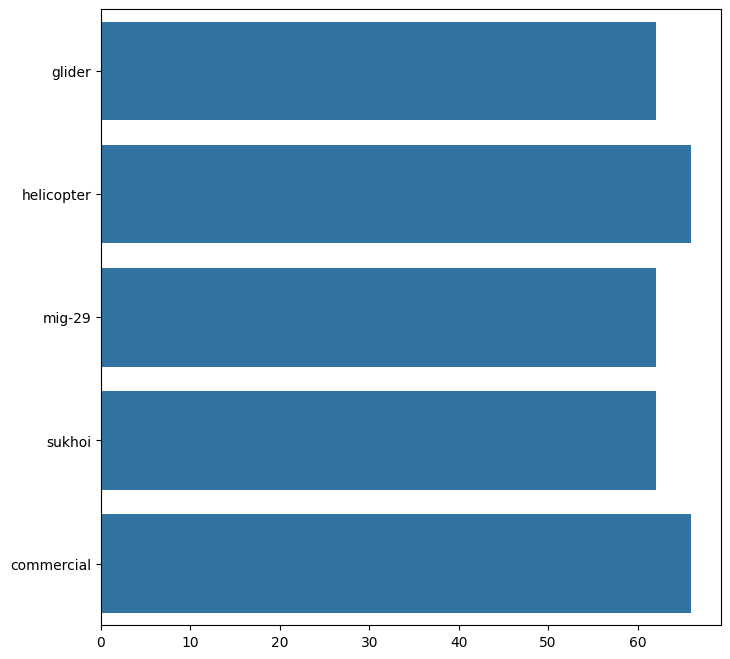

In [7]:
species = train[0][1]
no_of_aeroplanes = []
for i in range(1, 6):
    no_of_aeroplanes.append(len(train[i][0]))
plt.figure(figsize = (8, 8))
sns.barplot(y = species, x = no_of_aeroplanes);

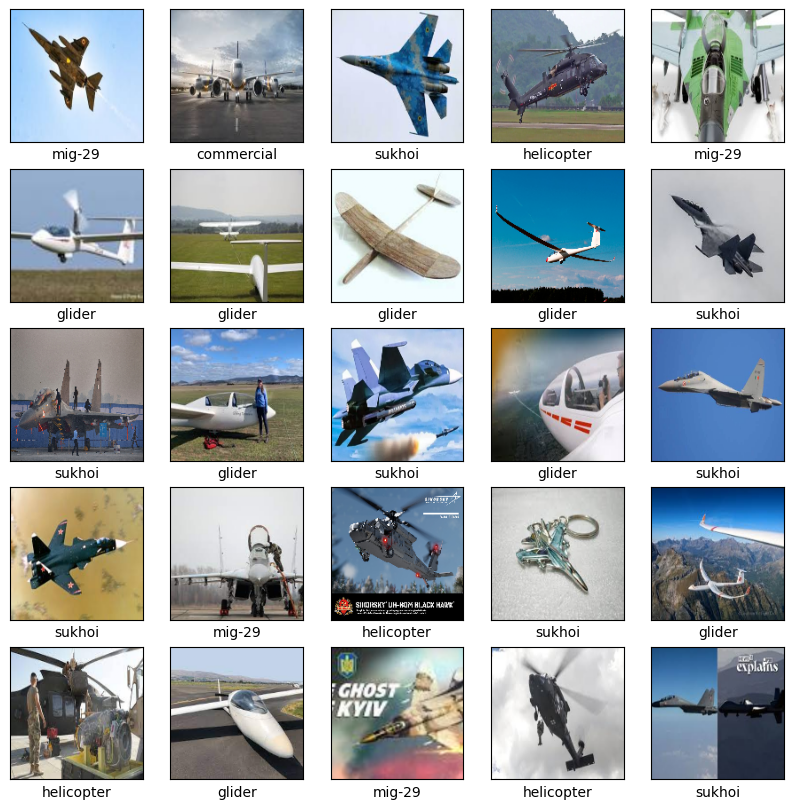

In [8]:
plt.figure(figsize = (10,10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.yticks([])
    plt.xticks([])
    plt.grid(False)
    data = images[i]
    plt.xlabel(label_names[labels[i]])
    plt.imshow(data);

# Preparing Dataset

In [9]:
image_size = (224, 224)
batch_size = 64
train_datagen = ImageDataGenerator(rescale = 1./255,
                            shear_range = 0.4,
                            zoom_range = 0.4,
                            horizontal_flip = True,
                            vertical_flip = True,
                            validation_split = 0.2)

In [10]:
train_ds = train_datagen.flow_from_directory('/kaggle/input/anyas-gojo-revival-aerospace-enigma/train',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'training',
                                      color_mode="rgb",)

val_ds = train_datagen.flow_from_directory('/kaggle/input/anyas-gojo-revival-aerospace-enigma/train',
                                      target_size = image_size,
                                      batch_size = batch_size,
                                      class_mode = 'categorical',
                                      subset = 'validation',
                                      color_mode="rgb")


Found 1875 images belonging to 5 classes.
Found 466 images belonging to 5 classes.


In [11]:
train_ds.class_indices

{'commercial': 0, 'glider': 1, 'helicopter': 2, 'mig-29': 3, 'sukhoi': 4}

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


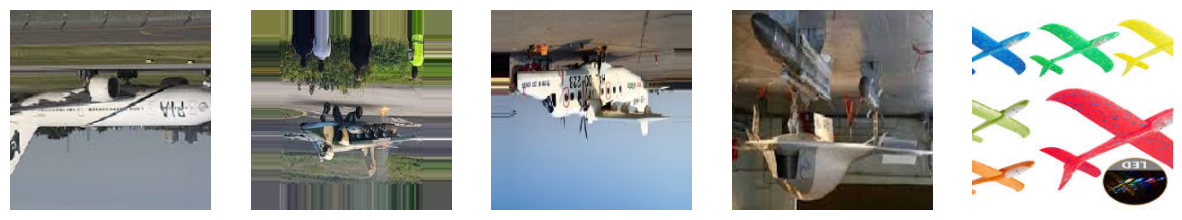

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(15,15))

for i in range(5):
    image = next(train_ds)[0][0]
    image = np.squeeze(image)
    ax[i].imshow(image)
    ax[i].axis(False)

# Xception(Fine Tuning)

In [13]:
xcep_base = applications.Xception(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))
xcep_base.trainable = False

inputs = Input(shape=(224, 224, 3))

x = xcep_base(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(1024, activation = 'relu')(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation = 'sigmoid')(x)
xcep_model = Model(inputs, outputs)

83683744/83683744 [==============================] - 5s 0us/step


In [14]:
xcep_model.compile(
    optimizer=keras.optimizers.Adam(),
    loss= keras.losses.CategoricalCrossentropy(from_logits = True),
    metrics= [keras.metrics.CategoricalAccuracy()],
)

In [15]:
def plot_results(history):
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()


In [16]:
epochs = 25
history=xcep_model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


30/30 [==============================] - 53s 1s/step - loss: 1.0299 - categorical_accuracy: 0.5808 - val_loss: 0.8490 - val_categorical_accuracy: 0.6137
Epoch 2/25
30/30 [==============================] - 38s 1s/step - loss: 0.7994 - categorical_accuracy: 0.6731 - val_loss: 0.6979 - val_categorical_accuracy: 0.7339
Epoch 3/25
30/30 [==============================] - 37s 1s/step - loss: 0.7188 - categorical_accuracy: 0.7067 - val_loss: 0.7246 - val_categorical_accuracy: 0.6867
Epoch 4/25
30/30 [==============================] - 37s 1s/step - loss: 0.6803 - categorical_accuracy: 0.7072 - val_loss: 0.7512 - val_categorical_accuracy: 0.6738
Epoch 5/25
30/30 [==============================] - 38s 1s/step - loss: 0.6822 - categorical_accuracy: 0.7104 - val_loss: 0.6995 - val_categorical_accuracy: 0.7124
Epoch 6/25
30/30 [==============================] - 39s 1s/step - loss: 0.6006 - categorical_accuracy: 0.7579 - val_loss: 0.6400 - val_categorical_accuracy: 0.7253
Epoch 7/25
30/30 [=========

In [17]:
xcep_model.metrics_names


['loss', 'categorical_accuracy']

# Evaluation

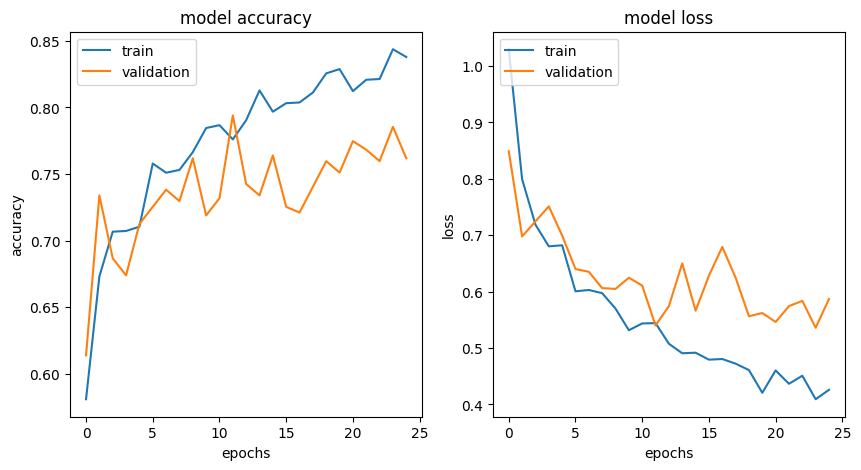

In [18]:
plot_results(history)

In [19]:
def predictor(img, model):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    image = np.array(image, dtype = 'float32')/255.0
    plt.imshow(image)
    image = image.reshape(1, 224,224,3)
    label_names = train_ds.class_indices
    clas = model.predict(image).argmax()
    name = clas
    print('The given image is of \nClass: {0} \nSpecies: {1}'.format(clas, name))

1/1 [==============================] - 2s 2s/step
The given image is of 
Class: 4 
Species: 4


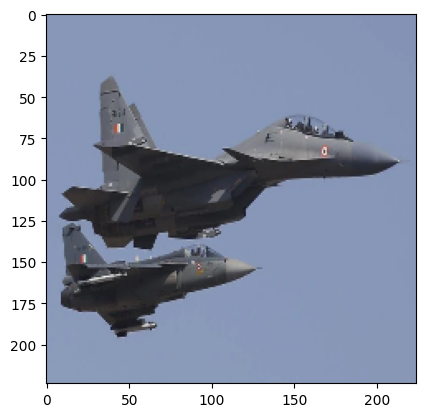

In [20]:
predictor('/kaggle/input/anyas-gojo-revival-aerospace-enigma/test/image223.jpg', xcep_model) #example image

# Test Prediction

In [21]:
test_path = '/kaggle/input/anyas-gojo-revival-aerospace-enigma/test'
X_test=[]
img_name_list = []

for img in os.listdir(test_path):
    img_path = test_path + '/' + img
    img_arr=cv2.imread(img_path)
    img_arr=cv2.resize(img_arr,(224,224))
    X_test.append(img_arr)
    img_name_list.append(img)

X_test = np.array(X_test).astype('float32')
X_test = X_test/255.0

y_pred_test = xcep_model.predict(X_test)
y_pred_test_final= []
for preds in y_pred_test:
    y_pred_test_final.append(np.argmax(preds))


9/9 [==============================] - 4s 118ms/step


In [22]:
train_path = '/kaggle/input/anyas-gojo-revival-aerospace-enigma/train'

#encoding the classes
code_to_cat = {}
cat_to_code = {}

code_to_cat[0]='commercial'
code_to_cat[1]='glider'
code_to_cat[2]='helicopter'
code_to_cat[3]='mig-29'
code_to_cat[4]='sukhoi'

In [23]:
cat_list = []
for i in y_pred_test_final:
    cat_list.append(code_to_cat[i])


In [24]:
import pandas as pd
data = {'image_path': img_name_list, 'class': cat_list}
sub_df = pd.DataFrame(data)
sub_df.set_index('image_path', inplace=True)
sub_df

,class
image_path,
image148.jpg,helicopter
image37.jpg,sukhoi
image46.jpg,commercial
image113.jpg,helicopter
image112.jpg,helicopter
...,...
image114.jpg,helicopter
image187.jpg,commercial
image146.jpg,helicopter


# Submission File

In [25]:
sub_df.to_csv('submission.csv')